In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
val_transforms=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(0.49,0.248),

])

In [4]:
import os 
print(os.getcwd())

c:\Users\milos\Projects\rsna-pneumonia-detection-challenge\Pneumonia detection project


In [5]:
val_dataset = torchvision.datasets.DatasetFolder(
    root=r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\Processed\val",
    loader=load_file,
    extensions=("npy",),
    transform=val_transforms
)


In [6]:
temp_model=torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [9]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

        
            
    def forward(self, data):
        
      
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))

        print(avg_pool_output.shape)
        avg_pool_output_flattened = torch.flatten(avg_pool_output,1)
        print(avg_pool_output_flattened.shape)

     
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [11]:

ckpt_path = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\logs\lightning_logs\version_5\checkpoints\best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt"

model = PneumoniaModel.load_from_checkpoint(ckpt_path, strict=False)


In [12]:
import torch
import torch.nn.functional as F

def cam(model, img):

    model.eval()
    with torch.no_grad():
        logits, feats = model(img.unsqueeze(0))      

    feats = feats.squeeze(0)                          
    C, H, W = feats.shape
    feat_flat = feats.reshape(C, H*W)                 

    
    fc_w = model.model.fc.weight[0]                   

   
    cam_vec = torch.matmul(fc_w, feat_flat)          
    cam_map = cam_vec.reshape(H, W)
    cam_map = F.relu(cam_map)

    
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-6)

    return cam_map.detach().cpu().float(), logits.detach().cpu()


In [13]:
import os
print(os.getcwd())


c:\Users\milos\Projects\rsna-pneumonia-detection-challenge\Pneumonia detection project


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize as tv_resize

def visualize(img, cam, pred, save_path=None):
   
    if torch.is_tensor(img):
        img = img.detach().cpu().numpy()
    if img.ndim == 3 and img.shape[0] == 1:      
        img = img[0]
    elif img.ndim == 3 and img.shape[0] == 3:    
        img = np.transpose(img, (1, 2, 0))

    H, W = (img.shape if img.ndim == 2 else img.shape[:2])

    
    if torch.is_tensor(cam):
        cam = cam.detach().cpu()
    cam_resized = tv_resize(cam.unsqueeze(0), (H, W))[0].numpy()
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-6)

    
    if torch.is_tensor(pred):
        prob = torch.sigmoid(pred).item()  
        pred_txt = f"prob: {prob:.2f}"
    else:
        pred_txt = str(pred)

    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img, cmap=None if img.ndim == 3 else "bone")
    ax[0].set_title("Image"); ax[0].axis("off")

    ax[1].imshow(img, cmap=None if img.ndim == 3 else "bone")
    ax[1].imshow(cam_resized, cmap="jet", alpha=0.5)
    ax[1].set_title(f"CAM overlay | {pred_txt}"); ax[1].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


torch.Size([1, 512, 1, 1])
torch.Size([1, 512])


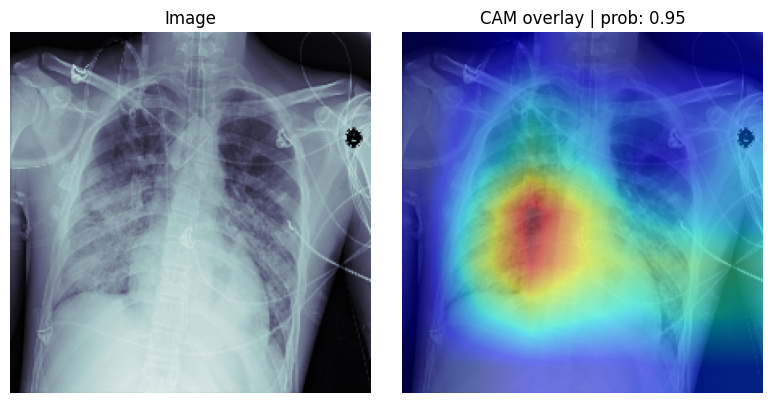

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

img = val_dataset[-15][0].to(device, dtype=torch.float32)

cam_map, pred = cam(model, img)        
visualize(img, cam_map, pred)
      



torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])


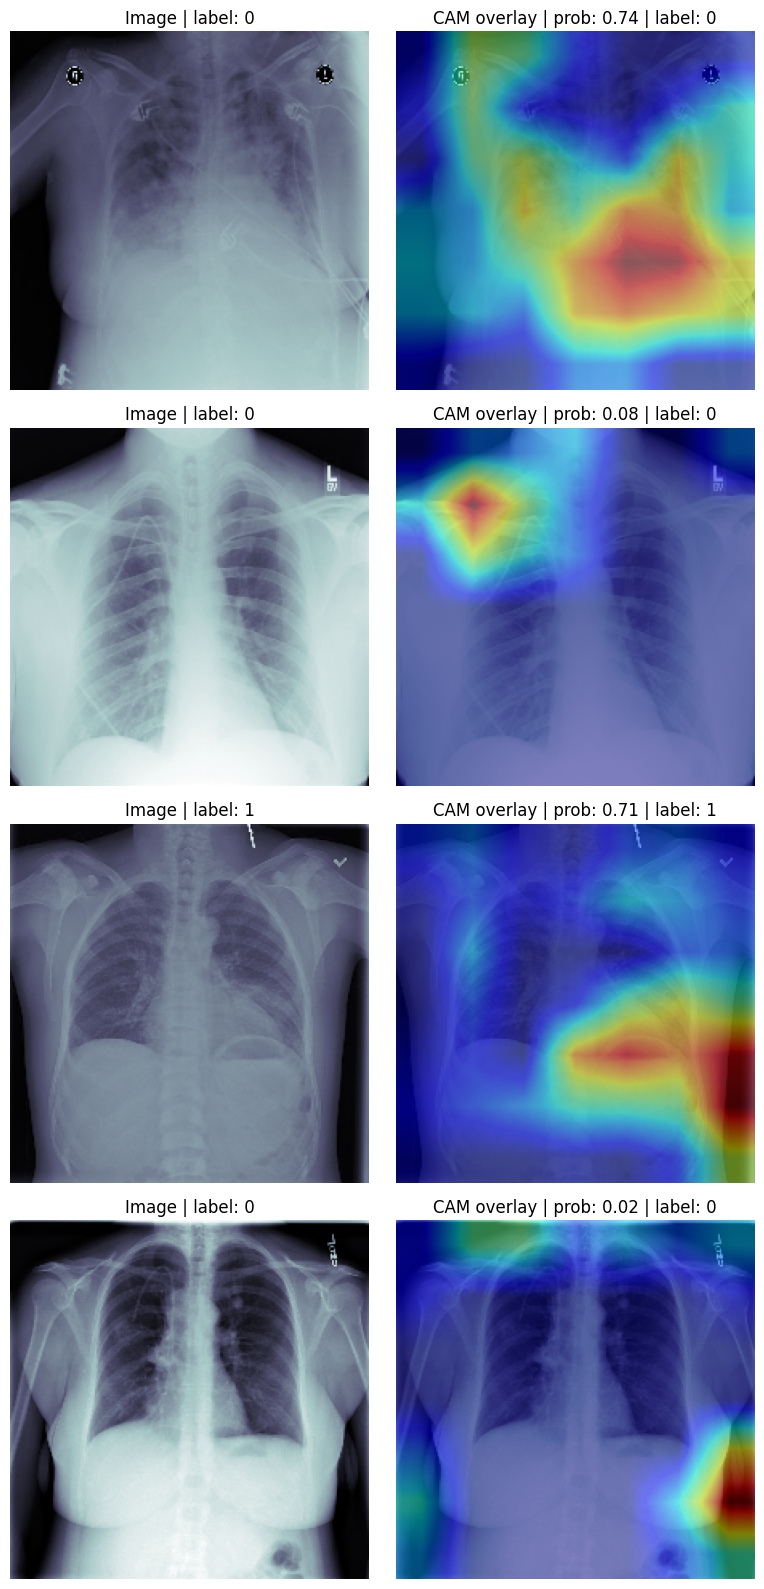

In [16]:
import random
import torch
import matplotlib.pyplot as plt

def show_random_cams(model, dataset, n=6, device="cuda"):
    model = model.to(device)
    model.eval()

    fig, axes = plt.subplots(n, 2, figsize=(8, 4*n))

    for i in range(n):
      
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]   
        img = img.to(device, dtype=torch.float32)

        
        cam_map, pred = cam(model, img)

       
        if n == 1:
            visualize(img, cam_map, pred)
        else:
            
            if torch.is_tensor(img):
                np_img = img.detach().cpu().numpy()
            if np_img.ndim == 3 and np_img.shape[0] == 1:  
                np_img = np_img[0]
            elif np_img.ndim == 3 and np_img.shape[0] == 3:
                np_img = np.transpose(np_img, (1,2,0))

            H, W = (np_img.shape if np_img.ndim==2 else np_img.shape[:2])
            cam_resized = torch.nn.functional.interpolate(
                cam_map.unsqueeze(0).unsqueeze(0), size=(H, W),
                mode="bilinear", align_corners=False
            )[0,0].cpu().numpy()

            cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-6)

            
            if pred.numel() == 1:
                prob = torch.sigmoid(pred).item()
                pred_txt = f"prob: {prob:.2f} | label: {label}"
            else:
                prob = torch.softmax(pred, dim=1)[0].max().item()
                pred_txt = f"top prob: {prob:.2f} | label: {label}"

            
            axes[i,0].imshow(np_img, cmap="bone")
            axes[i,0].set_title(f"Image | label: {label}")
            axes[i,0].axis("off")

           
            axes[i,1].imshow(np_img, cmap="bone")
            axes[i,1].imshow(cam_resized, cmap="jet", alpha=0.5)
            axes[i,1].set_title(f"CAM overlay | {pred_txt}")
            axes[i,1].axis("off")

    plt.tight_layout()
    plt.show()



show_random_cams(model, val_dataset, n=4, device=device)